# Storing Pulse Templates: Serialization

So far, we have constructed new pulse templates in code for each session (which were discarded afterwards). We now want to store them persistently in the file system to be able to reuse them in later sessions. For this, qctoolkit offers us serialization and deserialization using the `Serializer` and `StorageBackend` classes.

## Serializing Atomic Templates
### Storing

In [9]:
from qctoolkit.pulses import TablePT
from qctoolkit.serialization import Serializer, FilesystemBackend

anonymous_table = TablePT({'A': [('ta', 'va', 'hold'),
                                            ('tb', 'vb', 'linear'),
                                            ('tend', 0, 'jump')]})

backend = FilesystemBackend("./legacy_serialized_pulses")
serializer = Serializer(backend)

serializer.serialize(anonymous_table, overwrite=True)

Assuming that we, again, have the `TablePulseTemplate` from [Modelling a Simple TablePulseTemplate](00SimpleTablePulse.ipynb) we instantiate a `Serializer` object to store it. `Serializer` requires a `StorageBackend` instance which represents the actual data storage. We provide a `FilesystemBackend` instance which will store data in the directory `./serialized_pulses`. With this setup, storing the pulse template simply means invoking the `serialize` method of the `Serializer` instance and passing in our template. This will store a JSON representation of the object in the specified storage. Since we have not provided any file name, `Serializer` chooses the file name as `main`.

To specify a name, we can provide an identifier as an argument to the constructor of any pulse template:

In [10]:
identified_table = TablePT({'A': [('ta', 'va', 'hold'),
                                            ('tb', 'vb', 'linear'),
                                            ('tend', 0, 'jump')]},
                                      identifier='table_template')

serializer.serialize(identified_table, overwrite=True)

This will create a file named `table_template` with the same contents as above.

### Loading

To load a previously stored pulse template, we use the method `Serializer.deserialize` with the file name. The following code will load a very simple table pulse template which ramps from 0 to 20 over a duration of 4 units of time and which is stored under the name `stored_template`:

<IPython.core.display.Javascript object>


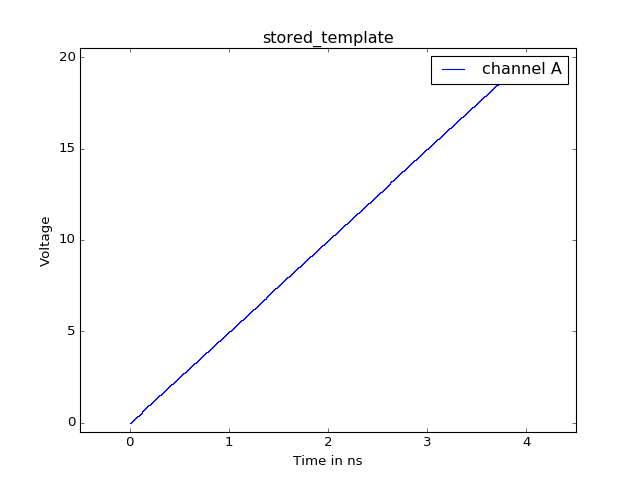

<IPython.core.display.Javascript object>


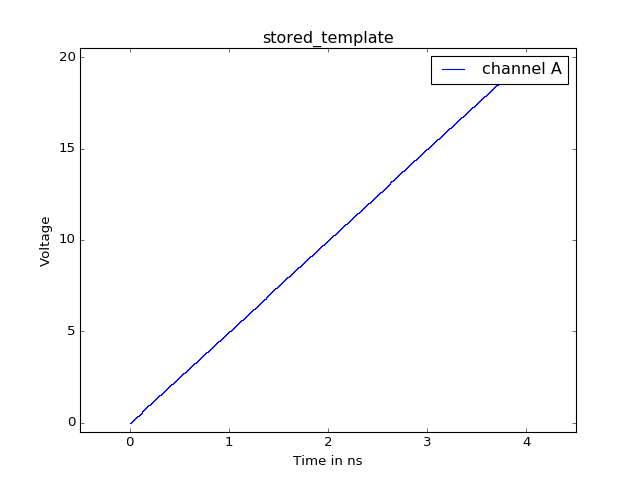

In [11]:
loaded_template = serializer.deserialize('stored_template')

%matplotlib notebook
from qctoolkit.pulses.plotting import plot

plot(loaded_template, sample_rate=100)

## Serializing Composite Templates

Serializing atomic templates (`TablePulseTemplate` and `FunctionPulseTemplate`) is a straightforward task. However, when storing composite templates that refer to subtemplates, e.g., `SequencePulseTemplate`, one must decide whether to embed the subtemplates into the composite's serialization or to store them separately. The latter one will be preferred if the subtemplate is used in several composite templates. `Sequencer` will decide whether to store a subtemplate separately based on the fact whether or not it provides an identifier: Subtemplates without an identifier will be embedded.

In [12]:
from qctoolkit.pulses import SequencePT

mapping = {
    'ta': '1',
    'tb': '2',
    'va': '5',
    'vb': '0',
    'tend': '5'
}
sequence1 = SequencePT((anonymous_table, mapping),
                                  external_parameters=set(),
                                  identifier='sequence_embedded')
serializer.serialize(sequence1, overwrite=True)

sequence2 = SequencePT((identified_table, mapping), identifier='sequence_referenced')
serializer.serialize(sequence2, overwrite=True)

The above code snippet creates two `SequencePulseTemplate`s consisting of only one table subtemplate (one of those defined above respectively). The `anonymous_table` is used in `sequence1`. Since it has no identifier, it is embedded in the serialization: `sequence_embedded`.

In contrast, the table subtemplate in `sequence2` has an identifier, so the serialization of `sequence2` will contain only a reference to the serialization of `identified_table`: `sequence_referenced`

## Storage Backends

So far, we have only used the `FilesystemBackend` to store pulse template directly in some folder. However, the abstraction of the `StorageBackend` theoretically allows us to implement other backends, e.g., a SQL database, without changing the `Serializer`.

Additionally, the class `CachingBackend` can be used to decorate and add caching functionality to any other `StorageBackend` instance to speed up loading of frequently accessed templates as follows:

In [13]:
from qctoolkit.serialization import CachingBackend
cached_serializer = Serializer(CachingBackend(FilesystemBackend("./serialized_pulses")))